
# 03 - Strategy Design
This notebook defines the trading signals for the mean-reversion strategy using the spread computed earlier.


In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:

# Load spread.csv as a Series
spread_df = pd.read_csv("../data/processed/spread.csv", index_col=0, parse_dates=True)
spread = spread_df.iloc[:, 0]  # take the first column as Series


# Function to compute z-score
def zscore(series):
    return (series - series.mean()) / series.std()

z = zscore(spread)

In [3]:
entry_z = 1.5
exit_z = 0.5
signals = pd.DataFrame(index=spread.index)
signals['position'] = 0
signals.loc[z > entry_z, 'position'] = -1
signals.loc[z < -entry_z, 'position'] = 1

# exit rule
signals['position'] = np.where(abs(z) < exit_z, 0, signals['position'])
signals['position'] = signals['position'].ffill().fillna(0)


In [4]:
# rolling standard deviation of spread
spread_std = spread.rolling(window=20).std()

# target volatility per trade (e.g., 1% of notional)
target_vol = 0.01

# adjust position size
signals['raw_position'] = signals['position']
signals['position'] = signals['position'] * (target_vol / spread_std)
signals['position'] = signals['position'].fillna(0)


In [5]:
# Save signals
signals.to_csv("../data/processed/signals.csv")


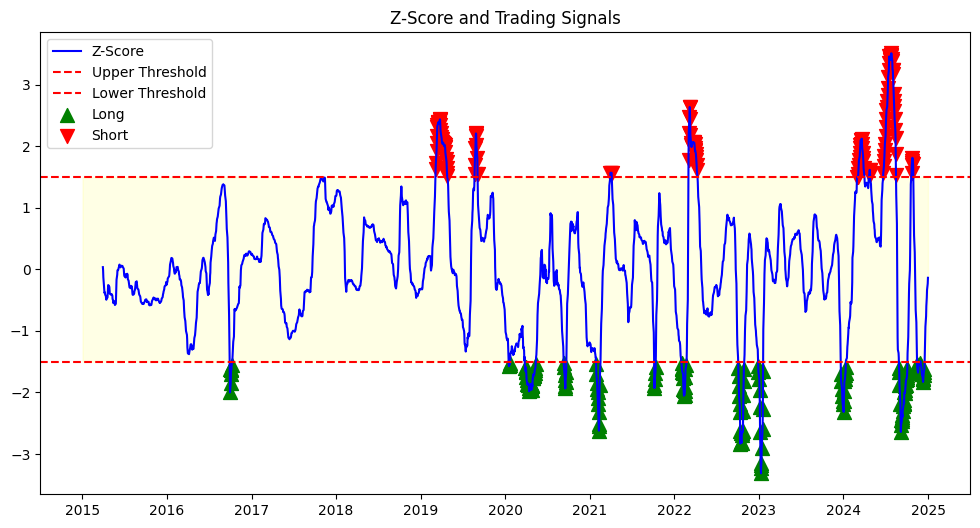

In [6]:
# Plot z-score and signals
plt.figure(figsize=(12,6))
plt.plot(z, label='Z-Score', color='blue')
plt.axhline(entry_z, color='r', linestyle='--', label='Upper Threshold')
plt.axhline(-entry_z, color='r', linestyle='--', label='Lower Threshold')
plt.fill_between(z.index, entry_z, -entry_z, color='yellow', alpha=0.1)

# highlight positions
long_signals = signals['position'] > 0
short_signals = signals['position'] < 0
plt.scatter(z.index[long_signals], z[long_signals], marker='^', color='green', label='Long', s=100)
plt.scatter(z.index[short_signals], z[short_signals], marker='v', color='red', label='Short', s=100)

plt.title("Z-Score and Trading Signals")
plt.legend()
plt.show()